In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from SuchTree import SuchTree, SuchLinkedTrees, pearson
import pandas as pd
import numpy as np
import seaborn

In [3]:
T1 = SuchTree( '../fishpoo/mcgee_trimmed.tree' )
T2 = SuchTree( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree' )
links = pd.read_csv( 'http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_host_count_table.tsv', 
                    sep='\t', index_col='Host')
links.index = map( lambda x : x.replace(' ','_'), links.index )

### Exploring our example data

Before we start with the science, let's use `SuchTree` to help us explore
the example data. We'll start by plotting a tree of `T1` using [`ete`]().
We will use `T1` later as the phylogeny of *host* organisms.

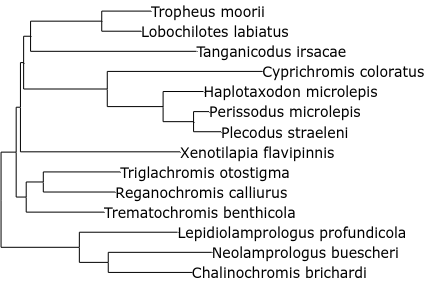

In [4]:
from ete2 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 1000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0

ete_tree = Tree( '../fishpoo/mcgee_trimmed.tree' )

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 10
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)

### Calculating distances

`SuchTree` has two ways to calculate distances; one pair at a time using 
`SuchTree.distance()`, or several large groups at once using `SuchTree.distances()`. 
The later avoids the interpreter's overhead and is much faster.

Note that the dendrograms in the cluster maps shown below are re-computed from 
the distances in the matrix using neighbor joining, and so they do not exactly match
the phylogeny. Send complaints to the authors of `seaborn`. 

First, here we'll calculate the matrix of patristic distances for `T1` using
`SuchTree.distance()`.

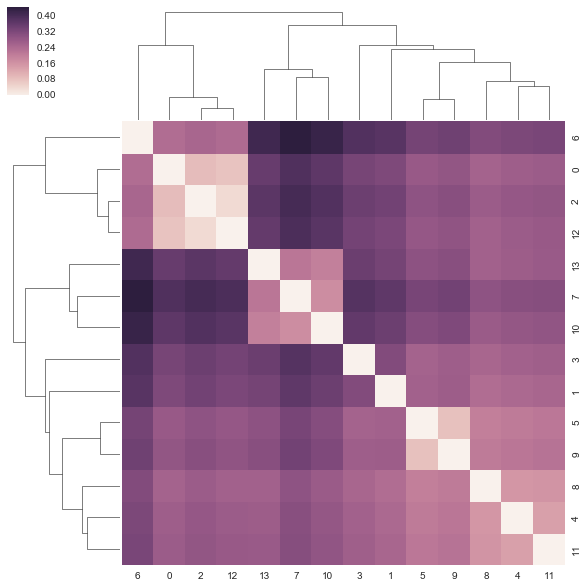

In [5]:
D1 = zeros( ( len(T1.leafs),len(T1.leafs) ) )
for i,a in enumerate(T1.leafs.values()) :
    for j,b in enumerate( T1.leafs.values() ) :
        D1[i,j] = T1.distance( a, b )
        
seaborn.clustermap(D1)

Here is the same calculation in batch mode using `SuchTree.distances()`.

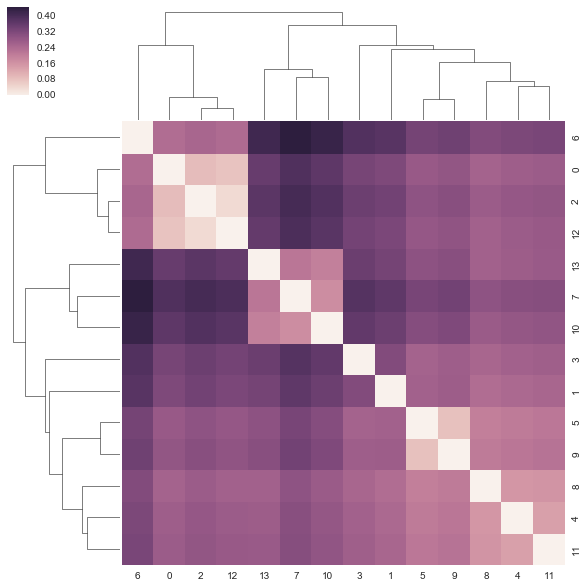

In [6]:
D2_list = []
for i,a in enumerate(T1.leafs.values()) :
    for j,b in enumerate( T1.leafs.values() ) :
        D2_list.append( ( a, b ) )
D2_array = array( D2_list )
D2 = T1.distances( D2_array )
D2 = D2.reshape( ( len(T1.leafs), len(T1.leafs) ) )
seaborn.clustermap(D2)

In [7]:
%%time
SLT = SuchLinkedTrees( T1, T2, links )

139771600864992 allocating columns in 480151288
bulding default subset.
bulding default link list.
CPU times: user 11min 28s, sys: 1.58 s, total: 11min 30s
Wall time: 11min 43s


In [8]:
SLT.TreeB.get_leafs( 7027 )

array([6936, 7040, 7046, 7052, 6880, 6938, 6940, 6942, 6994, 7028, 7034,
       7042, 7044, 7048, 7050, 7054, 7056, 6882, 6944, 6950, 6996, 6998,
       7014, 7030, 7032, 7036, 7038, 6884, 6886, 6926, 6932, 6934, 6946,
       6948, 6952, 6954, 7000, 7008, 6914, 6916, 6918, 6920, 6928, 6930,
       6972, 6986, 7002, 7010, 7012, 7016, 7024, 7026, 6888, 6890, 6892,
       6922, 6924, 6956, 6958, 6960, 6962, 6964, 6974, 6980, 6992, 7004,
       7006, 7022, 6894, 6896, 6898, 6906, 6966, 6976, 6978, 6982, 6984,
       6988, 6990, 7018, 7020, 6900, 6908, 6968, 6970, 6902, 6904, 6910,
       6912])

In [9]:
SLT.subset_b( 7027 )
print 'subset size, a :', SLT.subset_a_size
print 'subset size, b :', SLT.subset_b_size
print 'subset links   :', SLT.subset_n_links
print 'link pairs     :', ( SLT.subset_n_links * ( SLT.subset_n_links -1 ) ) / 2

subset size, a : 14
subset size, b : 89
subset links   : 337
link pairs     : 56616


In [10]:
print SLT.col_ids
print SLT.subset_columns
print SLT.subset_b_leafs

[ 77012 106174 100632 ...,  60496  40312  67012]
[37633 25708 51090 17894 20203 28821 30994 51224 29565 37352 27576 37745
  5083  7167 29305 21102  2900 45778 12785 43434 28605 50204 42422 37275
 33623 28599   702 22655  8894 16086 52753  7036 22235 29536 25752 19840
 25913 45302  7254 11458 46359 17008 17559 13866 13594 30210 42254 35039
 51425 38488 26463 19919 21829 33133  7334 23312 43075 15132 11588 14504
 38995 14011 31929 26999 51838  5457 31613 17337 50120 27007 49497 28213
 45249 47995 41296 44556  4512  5212 16829 50626 26848 50728   386 32460
 19676 48859 24163  5066 36179]
[6936 7040 7046 7052 6880 6938 6940 6942 6994 7028 7034 7042 7044 7048 7050
 7054 7056 6882 6944 6950 6996 6998 7014 7030 7032 7036 7038 6884 6886 6926
 6932 6934 6946 6948 6952 6954 7000 7008 6914 6916 6918 6920 6928 6930 6972
 6986 7002 7010 7012 7016 7024 7026 6888 6890 6892 6922 6924 6956 6958 6960
 6962 6964 6974 6980 6992 7004 7006 7022 6894 6896 6898 6906 6966 6976 6978
 6982 6984 6988 6990 7018 70

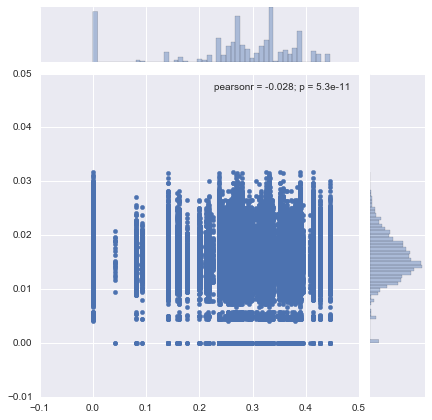

In [11]:
result = SLT.linked_distances()
seaborn.jointplot( result['TreeA'], result['TreeB'] )

In [12]:
SLT.subset_a( 1 )
print 'subset size, a :', SLT.subset_a_size
print 'subset size, b :', SLT.subset_b_size
print 'subset links   :', SLT.subset_n_links
print 'link pairs     :', ( SLT.subset_n_links * ( SLT.subset_n_links -1 ) ) / 2

subset size, a : 2
subset size, b : 89
subset links   : 13
link pairs     : 78


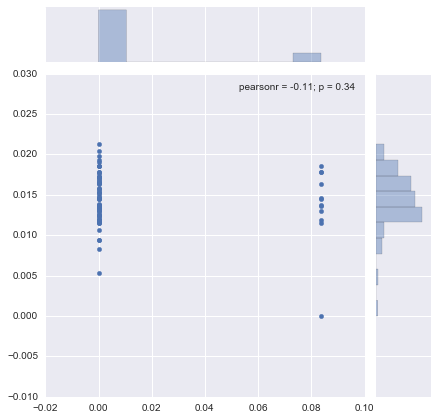

In [13]:
result = SLT.linked_distances()
seaborn.jointplot( result['TreeA'], result['TreeB'] )

In [14]:
SLT.subset_a( SLT.TreeA.root )
print 'subset size, a :', SLT.subset_a_size
print 'subset size, b :', SLT.subset_b_size
print 'subset links   :', SLT.subset_n_links
print 'link pairs     :', ( SLT.subset_n_links * ( SLT.subset_n_links -1 ) ) / 2

subset size, a : 14
subset size, b : 89
subset links   : 337
link pairs     : 56616


In [15]:
SLT.get_column_leafs( 0, as_row_ids=True )

array([11])

In [16]:
SLT.get_column_links( 0 )

array([False, False, False, False, False, False, False, False, False,
       False, False,  True, False, False], dtype=bool)

In [17]:
result_sampled = SLT.sample_linked_distances(sigma=0.05, n=10000, buckets=10)
result_sampled

{'TreeA': array([ 0.27549601,  0.23747799,  0.31190002, ...,  0.        ,
         0.        ,  0.31576499]),
 'TreeB': array([ 0.01982,  0.01597,  0.02479, ...,  0.01499,  0.01993,  0.0165 ]),
 'deviation_a': 0.0014004874974489212,
 'deviation_b': 2.508725447114557e-05,
 'n_pairs': 56616,
 'n_samples': 100000}

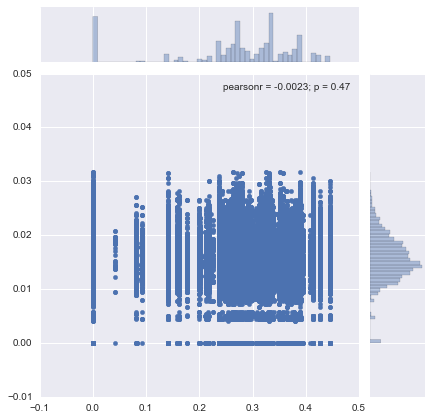

In [18]:
seaborn.jointplot( result_sampled['TreeA'], result_sampled['TreeB'] )

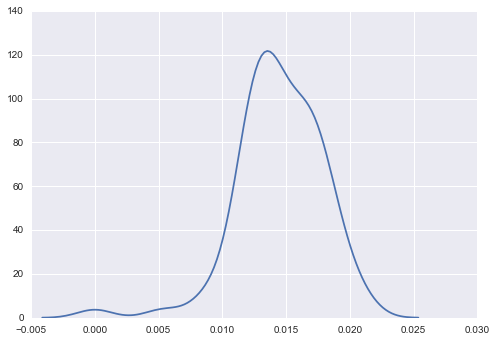

In [19]:
seaborn.kdeplot(result['TreeB'])

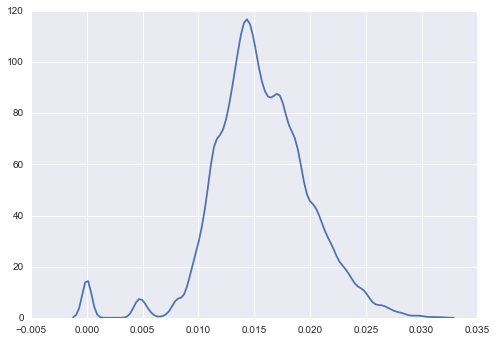

In [20]:
seaborn.kdeplot(result_sampled['TreeB'])


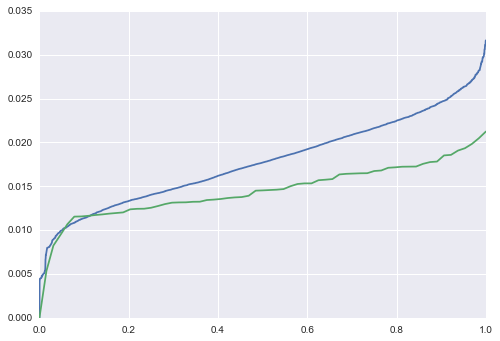

In [21]:
sd = sorted(list(set(result_sampled['TreeB'])))
ad = sorted(list(set(result['TreeB'])))

plot( linspace(0,1,len(sd)), sd )
plot( linspace(0,1,len(ad)), ad )


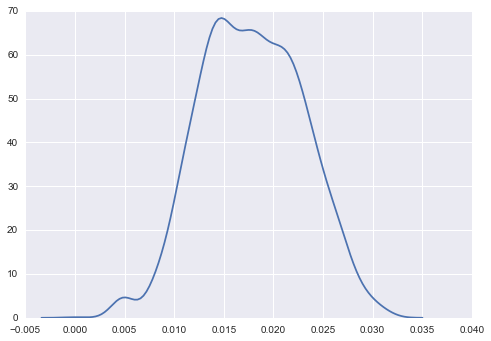

In [22]:
seaborn.kdeplot(array(sd))

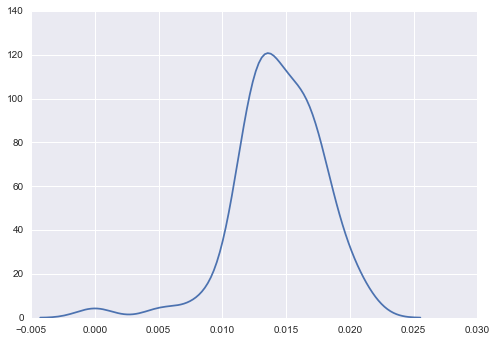

In [23]:
seaborn.kdeplot(array(ad))

In [ ]:
import pyprind

p = pyprind.ProgBar( len( list( SLT.TreeB.get_internal_nodes() ) ), monitor=True, title='sampling trees...' )

big_nodes = []
table = {}
for n,node in enumerate( SLT.TreeB.get_internal_nodes() ) :
    p.update()
    SLT.subset_b( node )
    if SLT.subset_n_links > 4000 :
        big_nodes.append( node )
        result = SLT.sample_linked_distances( sigma=0.05, n=1000, buckets=100)
    else :
        result = SLT.linked_distances()
    table[node] = { 'n_leafs'    : SLT.subset_b_size, 
                    'n_links'    : SLT.subset_n_links,
                    'n_pairs'    : result['n_pairs'],
                    'n_samples'  : result['n_samples'],
                    'deviatnon_a': result['deviation_a'],
                    'deviation_b': result['deviation_b'],
                    'r'          : pearson( result['TreeA'], result['TreeB'] ) }

In [24]:
#C.to_csv( 'docs/fishpoo.csv' )
C = pd.DataFrame.from_csv( 'docs/fishpoo.csv' )

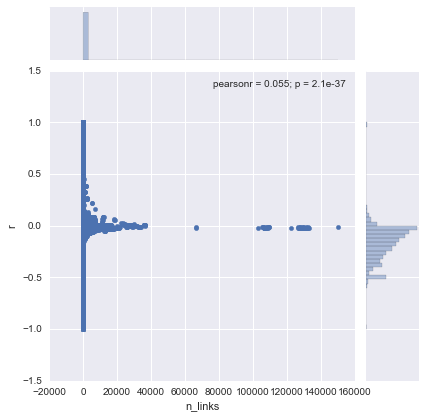

In [26]:
#C = pd.DataFrame( table ).T
seaborn.jointplot( 'n_links', 'r', data=C )

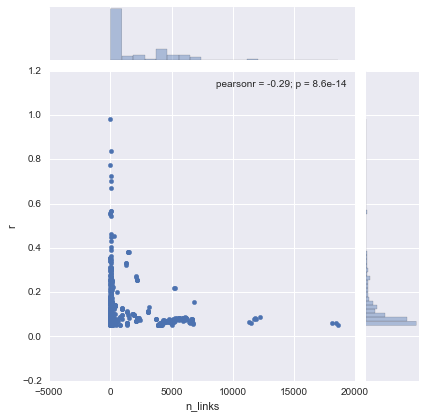

In [27]:
seaborn.jointplot( 'n_links', 'r', data=C.query('n_leafs > 5 and r > 0.05')  )

In [129]:
CC = C.query('n_leafs > 5 and r > 0.2').sort_values('r', ascending=False)
print CC.shape
CC.head()

(93, 7)


,deviation_b,deviatnon_a,n_leafs,n_links,n_pairs,n_samples,r
15421,NaN,NaN,10.0,10.0,45.0,45.0,0.979979
23887,NaN,NaN,33.0,34.0,561.0,561.0,0.836901
14909,NaN,NaN,6.0,6.0,15.0,15.0,0.776373
42253,NaN,NaN,46.0,53.0,1378.0,1378.0,0.722426
23003,NaN,NaN,22.0,22.0,231.0,231.0,0.699994


In [ ]:
from scipy.stats import kendalltau, pearsonr

pearson_p   = {}
kendall_tau = {}
kendall_p   = {}

for n,node in enumerate( CC.index ) :
    SLT.subset_b(node)
    result = SLT.linked_distances()
    p_r,p_p = pearsonr(   result['TreeA'], result['TreeB'] )
    k_t,k_p = kendalltau( result['TreeA'], result['TreeB'] )
    pearson_p[node]  = p_p
    kendall_tau[node] = k_t
    kendall_p[node]   = k_p

CC['pearson_p'] = pd.Series(pearson_p)
CC['kendall_tau'] = pd.Series(kendall_tau)
CC['kendall_p'] = pd.Series(kendall_p)
#CC.head()
#CC

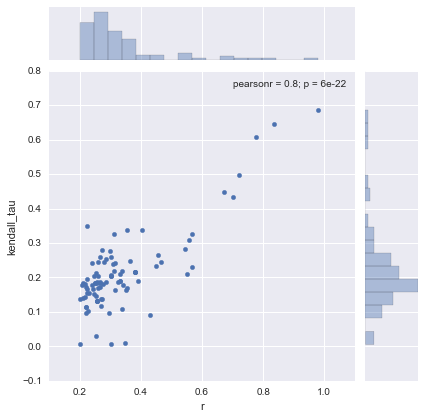

In [132]:
seaborn.jointplot( 'r', 'kendall_tau', data=CC ) 

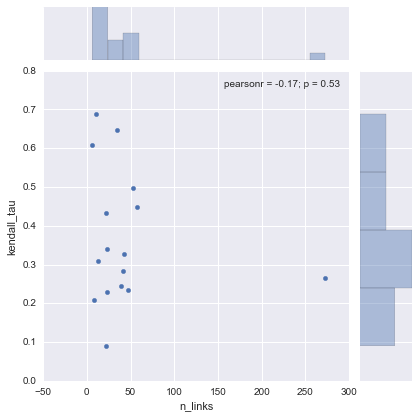

In [30]:
seaborn.jointplot( 'n_links', 'kendall_tau', data=CC )

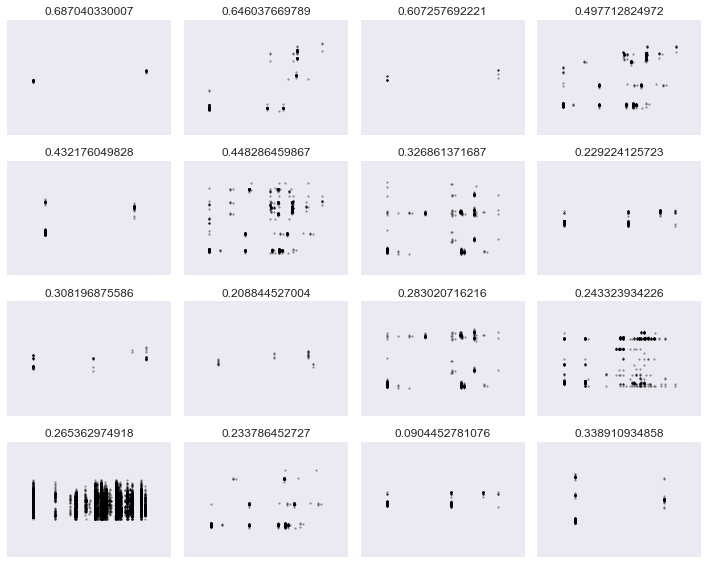

In [31]:
figure(figsize=(10,8))

for n,(node_id,row) in enumerate( CC.iterrows() ) :
    data = dict(row)
    subplot(4,4,n+1)
    SLT.subset_b( node_id )
    result = SLT.linked_distances()
    scatter( result['TreeA'], result['TreeB'], marker='o', s=3, c='black', alpha=0.4 )
    xticks([])
    yticks([])
    xlim((-0.1,max( result['TreeA'] )+0.1))
    ylim((-0.1,max( result['TreeB'] )+0.1))
    title( data['kendall_tau'] )

tight_layout()

In [32]:
from skbio import TreeNode

skt = TreeNode.read('http://edhar.genomecenter.ucdavis.edu/~russell/fishpoo/fishpoo2_p200_c2_unique_2_clustalo_fasttree.tree', convert_underscores=False)

In [124]:
cladeid = 31019
SLT.subset_b(cladeid)

sfeal = dict( zip(SLT.TreeB.leafs.values(), SLT.TreeB.leafs.keys() ) )
clade_leafs = map( lambda x : sfeal[x], SLT.subset_b_leafs )

clade = skt.shear( clade_leafs )
clade.children[0].length = 0
clade.write( str(cladeid) + '.tree' )

'31019.tree'

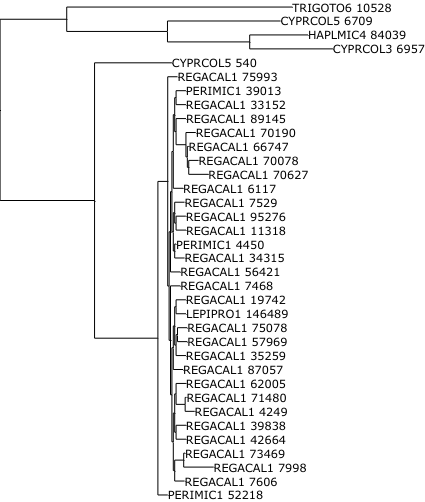

In [125]:
from ete2 import Tree, TreeStyle, NodeStyle, TextFace
from numpy import linspace

ts = TreeStyle()
ts.mode = 'r'
ts.show_leaf_name = True
ts.branch_vertical_margin = 2
ts.scale = 30000
ts.show_leaf_name = False
ts.show_scale = False

nstyle = NodeStyle()
nstyle['size'] = 0

ete_tree = Tree( str(cladeid) + '.tree' )

for node in ete_tree.traverse() :
    node.set_style(nstyle)
    if node.is_leaf :
        tf = TextFace( node.name.replace('_',' ').replace('\'','') )
        tf.fsize = 100
        tf.hz_align = 100
        node.add_face( tf, 0 )

ete_tree.render("%%inline", w=120, units="mm", tree_style=ts)

In [46]:
clinks = links[ clade_leafs ]
uclinks = clinks.applymap( bool ).unstack()
uclinks = uclinks[ uclinks ]
with open( str(cladeid) + '.links', 'w' ) as f :
    for pair in list(uclinks.index) :
        f.write( '\t'.join(pair) + '\n' )

In [94]:
with open( str(cladeid) + '.rev_links', 'w' ) as f :
    for pair in list(uclinks.index) :
        f.write( '\t'.join(pair[::-1]) + '\n' )

In [ ]:
from screed import ScreedDB, read_fasta_sequences

read_fasta_sequences( 'fishpoo2_p200_c2_unique_2_clustalo.fasta' )

db = ScreedDB( 'fishpoo2_p200_c2_unique_2_clustalo.fasta' )

In [ ]:
with open( str(cladeid) + '.aln.fasta', 'w' ) as f :
    for leaf in clade_leafs :
        a = db[leaf]
        f.write( '>' + a.name + '\n' + str(a.sequence) + '\n' )

In [ ]:
tgl_template = """#NEXUS
BEGIN HOST; 
	TREE * Host1 = HOST_TREE 
ENDBLOCK; 
 
BEGIN PARASITE;
	TREE * Para1 = GUEST_TREE
ENDBLOCK; 
 
BEGIN DISTRIBUTION; 
	RANGE
LINK_LINES
	; 
END;
"""

links = ''
for i,row in clinks.iterrows() :
    l = dict(row[row>0]).keys()
    if not l : continue
    links = links + '		' + i + ' : ' + ', '.join( l ) + '\n'

host_tree = open( '../fishpoo/mcgee_trimmed.tree' ).read()
guest_tree = open( str(cladeid) + '.tree' ).read()

with open( str(cladeid) + '.tgl', 'w' ) as f :
    f.write(tgl_template.replace('LINK_LINES',links[:-1]).replace('HOST_TREE',host_tree).replace('GUEST_TREE',guest_tree))

In [35]:
%load_ext rpy2.ipython

In [162]:
%%R

library('phytools')
source("http://www.phytools.org/cophylo/v0.1/cophylo.R")

tr1 <- read.tree( 'mcgee.tree' )
tr2 <- read.newick( '23887_noquote.tree' )
assoc = as.matrix(read.csv( '23887.rev_links', sep='\t', header=FALSE ))
colnames(assoc)<-c('tips.tr1','tips.tr2')

cophylo( tr1, tr2, assoc=assoc )


Error in assoc[sapply(tr1$tip.label, function(x, y) which(y == x), y = assoc[,  : 
  invalid subscript type 'list'


In [92]:
clinks.applymap( lambda x: 1 if x > 0 else 0 ).to_csv( str(cladeid) + '_linktable.csv' )

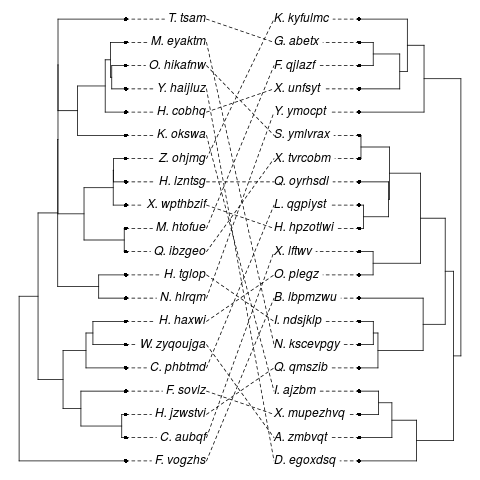

In [165]:
%%R

N<-20
tips.tr1<-replicate(N,paste(sample(LETTERS,1),"._",
    paste(sample(letters,round(runif(n=1,min=4,max=8))),
    collapse=""),sep=""))
tips.tr2<-replicate(N,paste(sample(LETTERS,1),"._",
    paste(sample(letters,round(runif(n=1,min=4,max=8))),
    collapse=""),sep=""))
tr1<-pbtree(n=N,tip.label=tips.tr1)
tr2<-pbtree(n=N,tip.label=sample(tips.tr2))
assoc<-cbind(tips.tr1,tips.tr2)
## here is our association matrix
assoc
obj <- cophylo( tr1, tr2, rotate=FALSE,  assoc=assoc )
plot(obj)

In [153]:
%%R

str(tr1$tip.label)

 chr [1:20] "H._gqeyun" "U._knfj" "X._sicrayk" "I._jzmwtuc" ...


In [150]:
%%R


#assoc = as.matrix(read.csv( '23887.rev_links', sep='\t', header=FALSE ))
#colnames(assoc)<-c('tips.tr1','tips.tr2')
#assoc

str(tr1$tip.label)

 chr [1:14] "Tropheus_moorii" "Lobochilotes_labiatus" ...


In [143]:
# because R is horrible
with open( 'mcgee.tree', 'w' ) as f :
    f.write( open( '../fishpoo/mcgee_trimmed.tree' ).read().replace('\'','') )
with open( '23887_noquote.tree', 'w' ) as f :
    f.write( open( '23887.tree' ).read().replace('\'','') )

In [156]:
%%R 
str(assoc)

 chr [1:34, 1:2] "Neolamprologus_buescheri" "Haplotaxodon_microlepis" ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "tips.tr1" "tips.tr2"


In [158]:
%%R
str(assoc)

 chr [1:20, 1:2] "R._bevy" "R._ilsfe" "D._nmlwxav" "P._uxcioth" ...
 - attr(*, "dimnames")=List of 2
  ..$ : NULL
  ..$ : chr [1:2] "tips.tr1" "tips.tr2"


In [163]:
%%R

tr2<-minRotate(tr2,setNames(1:Ntip(tr2),
				assoc[sapply(tr1$tip.label,function(x,y) which(y==x),y=assoc[,1]),2]),
				print=FALSE)


Error in assoc[sapply(tr1$tip.label, function(x, y) which(y == x), y = assoc[,  : 
  invalid subscript type 'list'


In [166]:
%%R

assoc[,1]

 [1] "F._vogzhs"   "C._aubqf"    "H._jzwstvi"  "F._sovlz"    "C._phbtmd"  
 [6] "W._zyqoujga" "H._haxwi"    "N._hlrqm"    "H._tglop"    "Q._ibzgeo"  
[11] "M._htofue"   "X._wpthbzif" "H._lzntsg"   "Z._ohjmg"    "K._okswa"   
[16] "H._cobhq"    "Y._haijluz"  "O._hikafnw"  "M._eyaktm"   "T._tsam"    
